目标：基于酒店运营数据，对顾客是否取消预定做预测

In [1]:
import warnings
warnings.filterwarnings('ignore')

#导入模型包
import sys,os
o_path='C:/Users/Ronal/Documents/Daria\'s Projects/share'
sys.path.append(o_path)

import pandas as pd

In [2]:
#加载数据集
df = pd.read_csv('hotel_bookings.csv')

In [3]:
#删除异常数据
df.drop(df[df['adults']+df['children']==0].index,inplace=True)
df.drop(df[df['adr']<0].index,inplace=True)
df.drop(df[df['market_segment']=='Undefined'].index,inplace=True)

In [4]:
#缺失值填充
# children字段中是数值型变量，且偏态分布，即用中位数替代
df["children"].fillna(df["children"].median(), inplace=True)
#country字段是类别变量，用众数填充
df['country'].fillna(df['country'].mode()[0],inplace=True)
#agent空值用0填充，表示没有代理
df['agent'].fillna(0,inplace=True)
#company缺失值太多，删除变量
del df['company']

In [5]:
#分离训练集测试集
#取前一年的数据作为训练集，后一年的数据作为测试集
train = df[(df['arrival_date_year']==2015) | ((df['arrival_date_year']==2016) & (df['arrival_date_month'].isin(['January','February','March','April','May','June'])))]
test =  df[(df['arrival_date_year']==2017) | ((df['arrival_date_year']==2016) & (~df['arrival_date_month'].isin(['January','February','March','April','May','June'])))]
d1 = train.groupby('is_canceled').count().iloc[:,0]
d2 = test.groupby('is_canceled').count().iloc[:,0]
print('train:',train.shape,'\ncanceled_rate:',round(d1[1]/(d1[0]+d1[1]),2))
print('test:',test.shape,'\ncanceled_rate:',round(d2[1]/(d2[0]+d2[1]),2))

train: (49106, 31) 
canceled_rate: 0.36
test: (70101, 31) 
canceled_rate: 0.38


In [6]:
from lrr_ML.binning import assign_box,feature_describe

In [14]:
train_x = train.loc[:,train.columns != 'is_canceled']
train_y = train['is_canceled']
test_x = test.loc[:,test.columns != 'is_canceled']
test_y = test['is_canceled']


#数据处理
for data in [train_x,test_x]:
    data['stay_days'] = data['stays_in_weekend_nights']+data['stays_in_week_nights']
    data['stay_days'] = data['stay_days'].map(lambda s:0 if s==0 else (1 if s<6 else (2 if s<11 else 3)))
    data['adr_pp'] = data['adr']/(data['adults']+data['children'])
    data['adr_pp'] = data['adr_pp'].map(lambda s:0 if s<23 else (1 if s<31 else (2 if s<33 else (3 if s<45 else (4 if s<46 else 5)))))
    data['required_car_parking_spaces'] = data['required_car_parking_spaces'].map(lambda s:int(s>0))
    data['total_of_special_requests'] = data['total_of_special_requests'].map(lambda s: 0 if s==0 else (1 if s<4 else 2))
    data['booking_changes'] = data['booking_changes'].map(lambda s:0 if s==0 else (1 if s<11 else 2))
    data['lead_time'] = data['lead_time'].map(lambda s:0 if s<5 else (1 if s<10 else (2 if s<26 else (3 if s<50 else (4 if s<235 else 5)))))
    data['days_in_waiting_list'] = data['days_in_waiting_list'].map(lambda s:int(s>0))
    
def fun_pre(s):
    if s['previous_cancellations']==0:
        if s['previous_bookings_not_canceled']==0:
            return 1
        else:
            return 2
    else:
        if s['previous_bookings_not_canceled']==0:
            return 3
        else:
            return 4
train_x.loc[train_x['is_repeated_guest']==1,'is_repeated_guest'] = train_x[train_x['is_repeated_guest']==1].apply(fun_pre,axis=1)
test_x.loc[test_x['is_repeated_guest']==1,'is_repeated_guest'] = test_x[test_x['is_repeated_guest']==1].apply(fun_pre,axis=1)

def fun_room(s):
    if s['reserved_room_type'] > s['assigned_room_type']:
        return 0
    elif s['reserved_room_type'] == s['assigned_room_type']:
        return 1
    else:
        return 2
train_x['room_type'] = train_x.apply(fun_room,axis=1)
test_x['room_type'] = test_x.apply(fun_room,axis=1)

train_country = train.groupby('country')['is_canceled'].agg({'count':'count','canceled':sum})
train_country['canceled_rate'] = train_country['canceled']/train_country['count']
country_d = dict(train_country['canceled_rate'])
train_x['country'] = train_x['country'].map(country_d)
test_x['country'] = test_x['country'].map(country_d)

x_assign,params = assign_box(train_x['country'],train['is_canceled'],rough_cut_groups_num=100)
train_x['country'] = x_assign
test_x['country'] = pd.cut(test_x['country'],params['cut_offs'],labels = params['cut_offs'][1:])
test_x['country'] = test_x['country'].map(params['df_feature_describe'].set_index('country')['woe'])
test_x['country'].fillna(train_x['country'].median(), inplace=True)
    
#类别变量数值化，canceled_rate
cat_cols = ['hotel','arrival_date_month','market_segment','deposit_type','customer_type','total_of_special_requests',
           'room_type','is_repeated_guest','stay_days','adr_pp','booking_changes','lead_time']
for c in cat_cols:
    df_feature = feature_describe(train_x[c],train_y)
    train_x[c] = train_x[c].map(df_feature.set_index(c)['woe'])
    test_x[c] = test_x[c].map(df_feature.set_index(c)['woe'])
    
for data in [train_x,test_x]:
    data['date'] = data['reservation_status_date'].map(lambda s:s[:7])
    data.set_index('date',inplace=True)
#剔除无关变量
del_cols = ['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights',
           'adults','children','babies','meal','distribution_channel','previous_cancellations','previous_bookings_not_canceled',
           'reserved_room_type','assigned_room_type','adr','reservation_status','reservation_status_date','agent']
for data in [train_x,test_x]:
    data.drop(del_cols,axis=1,inplace=True)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lrr_ML.evaluation import plot_auc_roc_ks,plot_confusion_matrix

In [20]:
lr = LogisticRegression(solver='liblinear',penalty='l2',C=0.01,random_state=62)
lr.fit(train_x,train_y)
predict = lr.predict(test_x)
preproab = lr.predict_proba(test_x)[:,1]


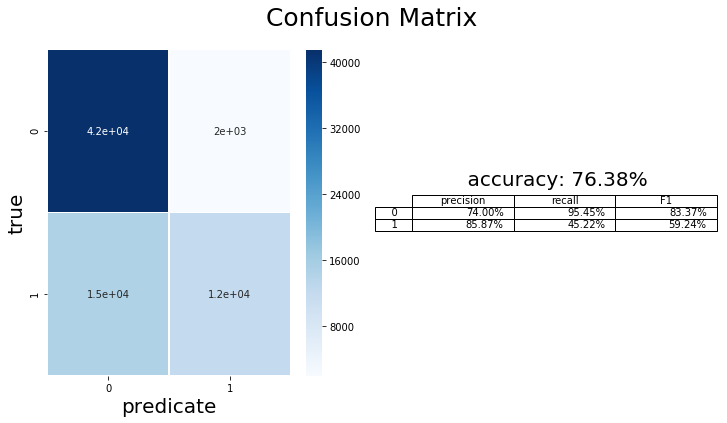

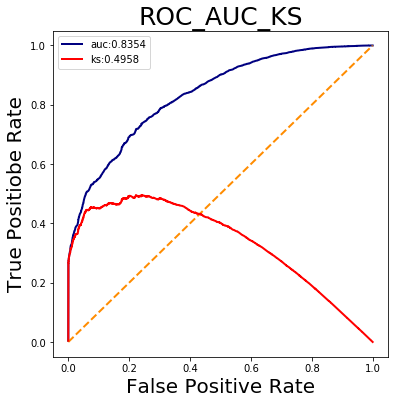

In [24]:
plot_confusion_matrix(predict,test_y)
plot_auc_roc_ks(preproab,test_y)

1. 准确率低和正样本分数低是样本不平衡的原因
2. 从ks和auc上看，lr变现还是不错的